In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
import plotly.io as pio
pio.renderers.default = "svg"

import pickle

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases (Synthetic.Household.Profiles.h5). Skip to next cell to use data sample from repository.

In [2]:
%%script false --no-raise-error
# Comment to execute

data = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]

data = data[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((data[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")

sub_house_ids = [house_ids[i] for i in [0, 4, 19, 13, 14]]
print(f"Average consumption is {round((data[sub_house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")

pv = data[["pv_1kw"]]
pd.to_pickle(pv, "pv.pickle")

load = data[sub_house_ids]
pd.to_pickle(_individuals, "house.pickle")
print("NOT skipped")

In [3]:
pv = pd.read_pickle("pv.pickle")
load = pd.read_pickle("house.pickle")
sub_house_ids = list(load.columns)

# I - Predictive approach

## Set up timeline and netload data

In [4]:
netload = load.copy()

# Fix variables
deltat = timedelta(minutes=15)

# Where do we forecast?
start = datetime(2019, 5, 30, 6, 0, 0)
full_horizon = timedelta(days=3)

# Trainning
training = timedelta(days=31)
start_training = start - training
end_training = start - deltat

# To truncate data
end = start + full_horizon + timedelta(days=7)  # keep a few days after anyway

pv_size = 3
netload = netload.loc[start_training-timedelta(days=1):end, :].copy()
for col in netload.columns:
    netload[col] -= pv_size * pv["pv_1kw"]

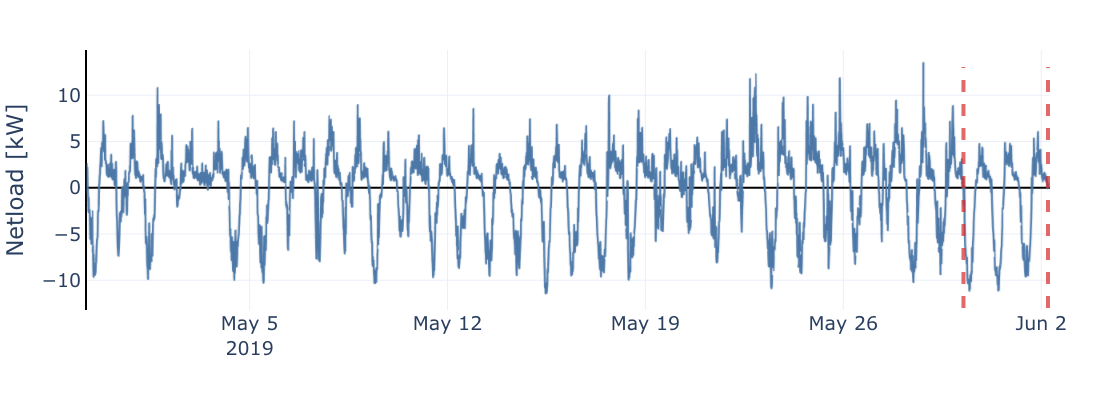

In [5]:
graph = netload.loc[start_training:start + full_horizon, :].sum(axis=1).copy()

fig = px.line(graph)
fig.data[0].update(line_width=2)

# Red dashed line
fig.add_shape(
 type='line',
 x0=start, x1=start, y0=-13, y1=13,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

# Red dashed line
fig.add_shape(
 type='line',
 x0=start+full_horizon-deltat,
 x1=start+full_horizon-deltat, y0=-13, y1=13,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    height=400,
    width=1100,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Netload [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show(renderer="png")
#fig.write_image(f"results/mpc_inputs.svg")

## Forecasting module

In [6]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet
from tqdm import tqdm

class GAM():
    """Generalized Additive Model.
    """

    def __init__(self, output, regressors=None,
                 daily_seasonality="auto",
                 seasonality_prior_scale=10.0):

        self._output = output
        self._model = Prophet(
            growth='flat',
            yearly_seasonality=False,
            weekly_seasonality="auto",
            daily_seasonality=daily_seasonality,
            seasonality_mode="additive",
            interval_width=0.95,
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=seasonality_prior_scale,
            uncertainty_samples=False,
        )
        if regressors is None:
            regressors = list()
        for reg in regressors:
            self._model.add_regressor(
                name=reg["name"],
                prior_scale=reg["prior_scale"])

    def fit(self, df):
        with suppress_stdout_stderr():
            self._model.fit(self._specific_formatting(df))

    def predict(self, df):
        forecast = self._model.predict(self._specific_formatting(df))
        forecast.set_index("ds", inplace=True, drop=True)
        forecast.drop(columns=forecast.columns.difference(["yhat"]), inplace=True)
        forecast.rename(columns={"yhat": self._output}, inplace=True)
        return forecast

    def _specific_formatting(self, df):
        df = df.copy()
        df["ds"] = df.index.tz_localize(None)
        df.rename(columns={self._output: "y"}, inplace=True)
        df.reset_index(inplace=True, drop=True)
        return df


class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


def get_gof(df, result, ref_col, pred_col):
    """
    gof = (1 - NRMSE) * 100
    """
    pred = result.loc[:, [pred_col]].copy()
    #if pred.index.tzinfo is None:
    #    pred.index = pred.index.tz_localize("UTC")
    pred.columns = ["prediction"]

    ref = df.loc[pred.index[0]:pred.index[-1], [ref_col]].copy()
    ref.columns = ["target"]

    nrmse = (np.linalg.norm(ref["target"].values - pred["prediction"].values, 2)
           / np.linalg.norm(ref["target"].values - ref["target"].mean(), 2))
    return 100.0 * (1.0 - np.clip(nrmse, a_min=0.0, a_max=1.0))

def lag_values(df, nb_lag, output_col):
    tmp = df.copy()
    for shift in nb_lag:
        tmp[f"t-{shift}"] = tmp[output_col].shift(shift)
    return tmp

###############
###############

def predict_n_periods_with_autoreg(df, start_training, end_training, horizon,
                                   deltat, end_complete_pred, freq, output_col,
                                   regressors, nb_lag, seasonality_prior_scale=1.0,
                                   disable_progress_bar=False, daily_seasonality="auto"):
    """
    Train a GAM and predict for horizon T
    Shift prediction start and predict over T again.

    results : [pd.DataFrame] One frame per prediction.
    """

    inputs = [reg["name"] for reg in regressors]
    results = []
    model = GAM(output_col, regressors, daily_seasonality=daily_seasonality,
                seasonality_prior_scale=seasonality_prior_scale)

    tmp = lag_values(df.loc[start_training-timedelta(days=1):end_training], nb_lag, output_col)
    model.fit(tmp.loc[start_training:end_training])

    # Number of forecast where we have access to actual data
    forecast_freq = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    for start_prediction in tqdm(forecast_freq, desc="# Forecast: ", disable=disable_progress_bar):
        tmp_results = []
        end_prediction = start_prediction + horizon

        # Get lagged values and NaN to blank future info
        tmp = lag_values(df.loc[start_prediction-timedelta(days=1):end_prediction], nb_lag, output_col)
        tmp = tmp.loc[start_prediction:end_prediction]
        for n in nb_lag:
            tmp.loc[:, f"t-{n}"] = tmp[f"t-{n}"].iloc[0:n].tolist() + ([np.nan] * (len(tmp) - n))

        horizon_spam = pd.date_range(start_prediction, end_prediction, freq="15T")
        for step_i, step in enumerate(horizon_spam):
            # Fill up NaN of lagged values with previous results
            for n in nb_lag:
                if pd.isna(tmp.at[step, f"t-{n}"]):
                    tmp.at[step, f"t-{n}"] = tmp_results[step_i-n]

            res = model.predict(tmp.loc[step:step, inputs])
            tmp_results.append(res.at[step, output_col])

        results.append(pd.DataFrame(index=horizon_spam, data={output_col: tmp_results}))
    return results, model

###############
###############

def model_3(graph, start_training, end_training, horizon,
            deltat, end_complete_pred, freq, output_col, scenario):
    """
    Wrapper around `predict_n_periods_with_autoreg()`
    """

    regressors = [{"name": "pv_1kw", "prior_scale": scenario["PRIOR_GHI"]}]

    for hour in range(0, 23):
        regressors.append({"name": f"h{hour}", "prior_scale": scenario["PRIOR_HOUR"]})

    nb_lag = list(range(1, scenario["NB_LAG"] + 1))
    for n in nb_lag:
        regressors.append({"name": f"t-{n}", "prior_scale": scenario["PRIOR_LAG"]})

    results, _ = predict_n_periods_with_autoreg(
        graph, start_training, end_training, horizon, deltat, end_complete_pred, freq, output_col,
        regressors,
        nb_lag=nb_lag,
        seasonality_prior_scale=scenario["PRIOR_SEASON"],
        daily_seasonality=scenario["DAILY_FOURIER"],
        disable_progress_bar=True)
    return results


## Fit and predict 

In [7]:
freqs = ["15T"]
freq_deltas = [timedelta(minutes=15) - deltat]

horizon = timedelta(days=2) - deltat
end_complete_pred = start + full_horizon

In [8]:
%%script false --no-raise-error
# Comment to execute

default_calibration = {
                 "NB_LAG": 10,
                 "PRIOR_GHI": 10.0,
                 "PRIOR_LAG": 10.0,
                 "PRIOR_HOUR": 10.0,
                 "PRIOR_SEASON": 1.0,
                 "DAILY_FOURIER": "auto"    
}
best_parameters = {name:dict(default_calibration) for name in sub_house_ids}

house_forecast = {}
for freq in freqs:
    print(f"Freq = {freq}")
    house_forecast[freq] = {}

    for house_id in tqdm(sub_house_ids, desc="House #"):

        graph = netload[[house_id]].copy()
        graph["pv_1kw"] = pv.loc[graph.index[0]:graph.index[-1], "pv_1kw"]

        graph["_datetime"] = graph.index
        for hour in range(0, 24):
            graph[f"h{hour}"] = graph._datetime.apply(lambda x: 1.0 if x.hour == hour else 0)
        graph.drop(columns="_datetime", inplace=True)
        
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            results = model_3(graph, start_training, end_training, horizon,
                        deltat, end_complete_pred, freq, house_id, bes t_parameters[house_id])

        house_forecast[freq][house_id] = [res.copy() for res in results]
    print("")

# Reformat as a dict of freq with a list of pd.DataFrame with all houses.
house_forecast_list = {}
for freq in freqs:
    house_forecast_list[freq] = []

    for i in range(0, len(house_forecast[freq][sub_house_ids[0]])):
        tmp = pd.concat([house_forecast[freq][house_id][i] for house_id in sub_house_ids], axis=1)
        house_forecast_list[freq].append(tmp)

# Store data (serialize)
with open('house_forecast_list.pickle', 'wb') as handle:
    pickle.dump(house_forecast_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Load data (deserialize)
with open('house_forecast_list.pickle', 'rb') as handle:
    house_forecast_list = pickle.load(handle)

15T

2000989


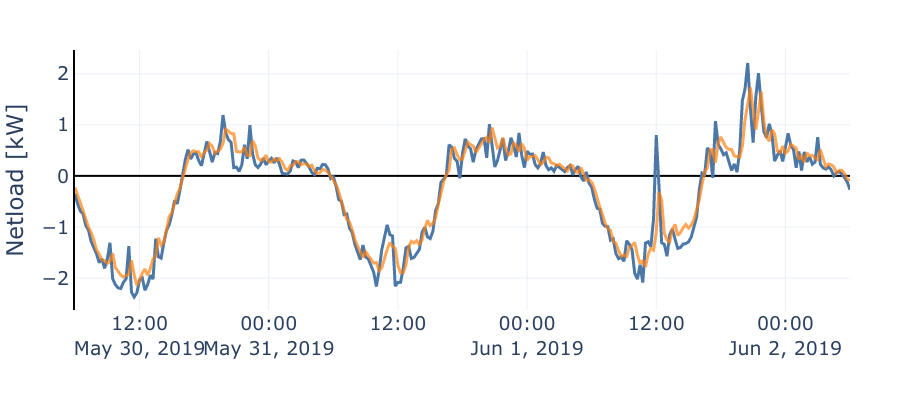

2000964


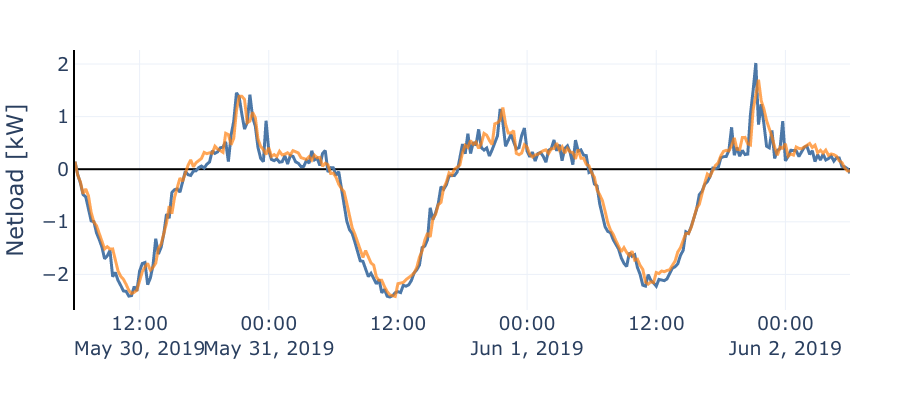

2000926


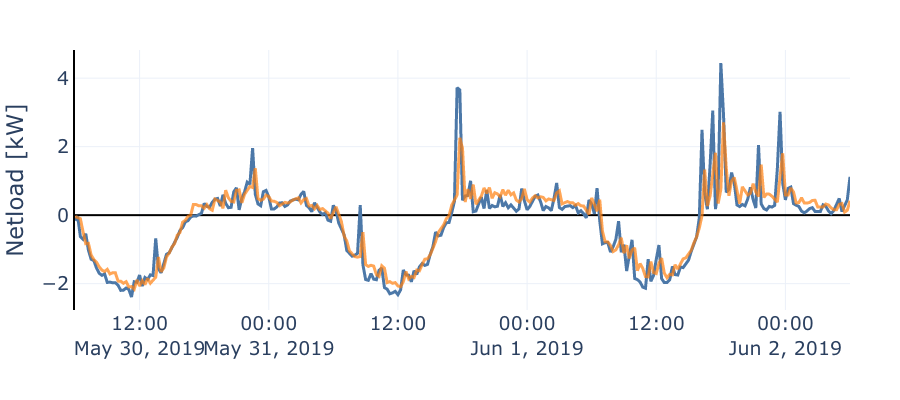

2001139


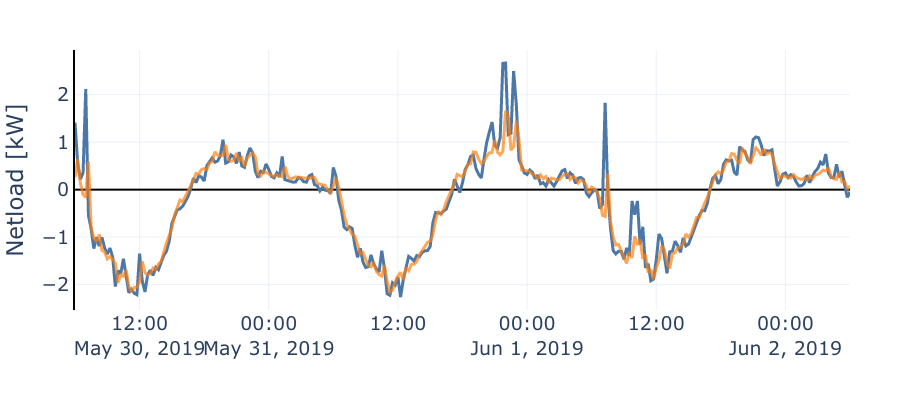

2000960


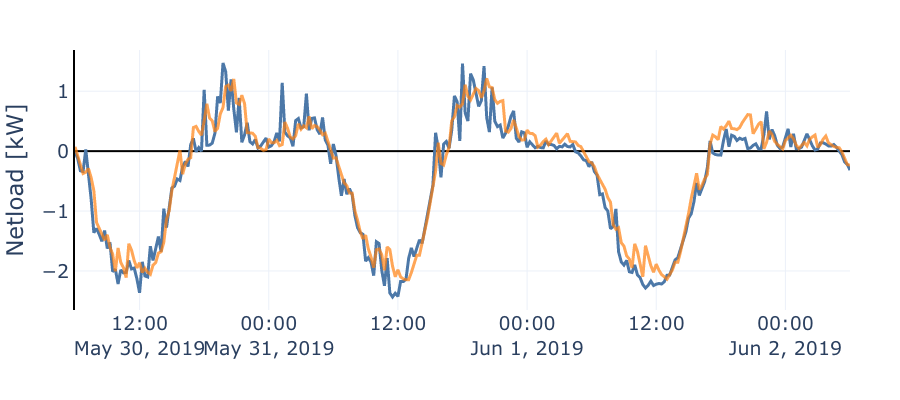

In [10]:
f = -1
freq = freqs[f]
freq_delta = freq_deltas[f]
print(freq)
print("")

for house_id in sub_house_ids:
    print(house_id)
    graph = netload.loc[start:end_complete_pred, [house_id]].copy()
    graph.columns = ["Ref"]

    fig = px.line(graph)
    fig.data[0].update(line_width=3)
    
    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    graph = pd.concat(tmp, axis=0)

    trace = px.line(graph[house_id].loc[start:end_complete_pred]).data[0]
    fig.add_trace(trace)
    fig.data[-1].update(line_width=3, line_color="rgba(255, 127, 14, 0.7)")

    fig.update_layout(
        layout,
        height=400,
        width=900,
        showlegend=False,
        xaxis_title="",
        yaxis_title="Netload [kW]",
        yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
        xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
        xaxis_tickangle=0)
    fig.show(renderer="png")
    #fig.write_image(f"results/_MPC_freq={freq}_horizon=2d_{house_id}.svg")

In [11]:
gofs = {house_id: list() for house_id in sub_house_ids}
for freq, freq_delta in zip(freqs, freq_deltas):

    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    graph = pd.concat(tmp, axis=0)        
    
    for house_id in sub_house_ids:
        gofs[house_id].append(get_gof(netload, graph.loc[start:end_complete_pred, :], house_id, house_id))

gofs = pd.DataFrame(index=freqs, data=gofs)
gofs.T

,15T
2000989,70.553662
2000964,80.708129
2000926,54.438809
2001139,65.061635
2000960,72.430141


## Predictive control

In [12]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "glpk"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_energy(m, b):
            return m.batteryenergy[m.last, b] >= batteries[b]["end_kwh"]

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )

        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
#--->?? #m.r6 = Constraint(m.batteries, rule=r_battery_end_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum(m.batteryin[i, b] for b in m.batteries)
                for i in m.horizon
            )

        m.objective = Objective(rule=objective_function, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, spec):
        netloads = df.copy()
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec[i]["min_kw"],
            "max_kw": spec[i]["max_kw"],
            "max_kwh": spec[i]["max_kwh"],
            "eta": spec[i]["eta"],
            "offset": spec[i]["offset"],
            "init_kwh": spec[i]["init_kwh"],
            #"end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

In [13]:
netload_freq = {}
for freq, freq_delta in zip(freqs, freq_deltas):

    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    
    netload_freq[freq] = pd.concat(tmp, axis=0)

In [14]:
schedules_concat = {}
energy_concat = {}
battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [dict(ref_spec) for i in sub_house_ids]

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=0,
                          verbose=False, only_return_schedules=False)

for freq, freq_delta in zip(freqs, freq_deltas):
    print(f"Freq = {freq}")
    schedules_concat[freq] = []
    energy_concat[freq] = []
    
    date_range = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    nb_iteration = len(date_range)
    for jndex, opti_start in tqdm(enumerate(date_range), desc="Opti #", total=nb_iteration):
        
        end_optimization = opti_start + horizon + deltat
        if end_optimization > end_complete_pred:
            end_optimization = end_complete_pred
        
        tmp_netload = netload_freq[freq].loc[opti_start:end_optimization, sub_house_ids]
        schedule = model.solve(tmp_netload, sub_house_ids, spec)
        
        # If not last iteration
        if not jndex == nb_iteration - 1:
            battery_time = opti_start + freq_delta + deltat
            for i, house_id in enumerate(sub_house_ids):
                spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])

        schedules_concat[freq].append(schedule["schedules"].loc[opti_start:opti_start+freq_delta].copy())
        energy_concat[freq].append(schedule["batteryenergy"].loc[opti_start:opti_start+freq_delta].copy())
    schedules_concat[freq] = pd.concat(schedules_concat[freq], axis=0)
    energy_concat[freq] = pd.concat(energy_concat[freq], axis=0)
    print("")

Opti #:   0%|          | 0/289 [00:00<?, ?it/s]

Freq = 15T


Opti #: 100%|██████████| 289/289 [02:19<00:00,  2.07it/s]


15T


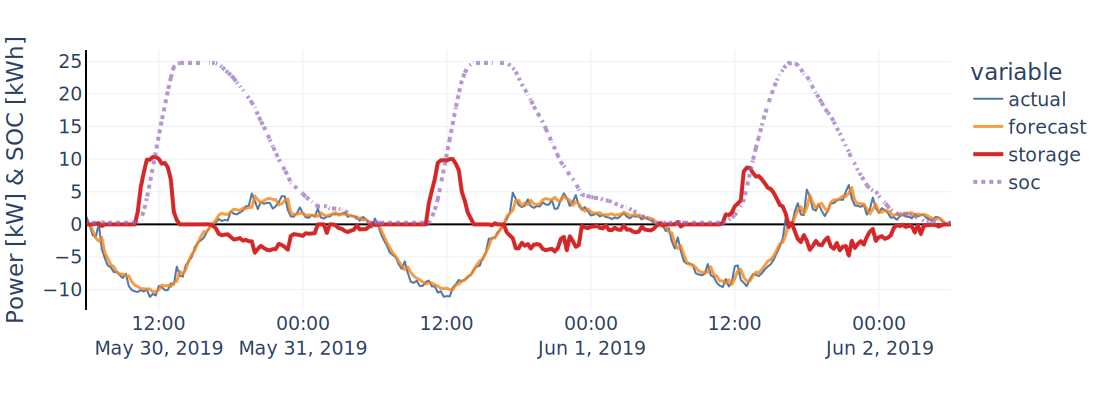

In [15]:
for freq, freq_delta in zip(freqs, freq_deltas):
    print(freq)
    
    graph = netload_freq[freq].copy()
    graph = graph.loc[:end_complete_pred, :]
    #graph = graph.loc[datetime(2019, 6, 1, 23, 0, 0):datetime(2019, 6, 5, 1, 0, 0), :]

    graph["forecast"] = graph.loc[:end_complete_pred, sub_house_ids].sum(axis=1)
    graph.drop(sub_house_ids, axis=1, inplace=True)

    graph["actual"] = netload.loc[graph.index[0]:graph.index[-1], sub_house_ids].sum(axis=1)

    graph["storage"] = schedules_concat[freq].sum(axis=1)
    graph["soc"] = energy_concat[freq].sum(axis=1)

    fig = px.line(graph, y=["actual", "forecast", "storage", "soc"])
    fig.data[1].update(line_width=3, opacity=0.8)
    fig.data[2].update(line_width=4, 
                       line_color="rgba(214, 39, 40, 1.0)")
    fig.data[3].update(line_width=4, 
                       line_dash="dot", line_color="rgba(148, 103, 189, 0.7)")
    fig.update_layout(
        layout,
        height=400,
        width=1100,
        showlegend=True,
        xaxis_title="",
        yaxis_title="Power [kW] & SOC [kWh]",
        yaxis_dtick=5,
        yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
        xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
        xaxis_tickangle=0)
    fig.show()

## Result in €

In [16]:
perfect_schedules_concat = []
perfect_energy_concat = []
perfect_communityimport_concat = []
spec = [dict(ref_spec) for i in sub_house_ids]

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371,
                          verbose=False, only_return_schedules=False)

for opti_start in tqdm(pd.date_range(end_training + deltat, end_complete_pred, freq="2D"), desc="Optimization #"):
    
    tmp_netload = netload.loc[opti_start:opti_start+horizon+deltat, sub_house_ids].copy()
    schedule = model.solve(tmp_netload, sub_house_ids, spec)
    
    battery_time = opti_start + horizon + deltat
    for i, house_id in enumerate(sub_house_ids):
        spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])
    
    perfect_schedules_concat.append(schedule["schedules"].loc[opti_start:opti_start+horizon].copy())
    perfect_energy_concat.append(schedule["batteryenergy"].loc[opti_start:opti_start+horizon].copy())
    perfect_communityimport_concat.append(schedule["community_import"].loc[opti_start:opti_start+horizon].copy())

perfect_schedules_concat = pd.concat(perfect_schedules_concat, axis=0)
perfect_energy_concat = pd.concat(perfect_energy_concat, axis=0)
perfect_communityimport_concat = pd.concat(perfect_communityimport_concat, axis=0)

Optimization #: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


In [17]:
def cost_wrapper(total_netloads):
    costs = []
    for index in total_netloads.index:
        cost = community_bill(total_netloads.loc[total_netloads.index[0]:index, :], sub_house_ids, 
                              timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
        costs.append(float(cost))
    return costs

def community_bill(df, member_ids, timing, deltat=15, buy_price=0.1740, exchange_price=0.0371):
    """Return cost for the community
    cost = buy [€/kWh] imports + pay fees on exchanges [€]
    """
    # Community import (sum then max)
    pos_netload = (
        (
            df[[a for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
            #- df[[prod_col for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
        )
        .clip(lower=0)
        .sum()
        * deltat
        / 60
    )

    # Sum of ind import (max then sum)
    pos_n_netload = (
        sum(
            (df[a]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            #(df[a] - df[prod_col]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            for a in member_ids
        )
        * deltat
        / 60
    )

    return np.round(
        buy_price * pos_netload + exchange_price * (pos_n_netload - pos_netload), 3
    )

_start = end_training + deltat
_end = end_complete_pred
freq = freqs[0]

# Predictive
total_netloads = schedules_concat[freq].loc[_start:_end, :].copy()
total_netloads.columns = sub_house_ids
for col in total_netloads.columns:
    total_netloads[col] += netload.loc[_start:_end, col]
costs = cost_wrapper(total_netloads)
graph = pd.DataFrame(index=total_netloads.index, data={"predictive": costs})

# Perfect
total_netloads = perfect_schedules_concat.loc[_start:_end, :].copy()
total_netloads.columns = sub_house_ids
for col in total_netloads.columns:
    total_netloads[col] += netload.loc[_start:_end, col]
costs = cost_wrapper(total_netloads)
graph["perfect"] = costs

# PV only
total_netloads = netload.loc[_start:_end, :].copy()
costs = cost_wrapper(total_netloads)
graph["pv only"] = costs

saved_graph = graph.copy()

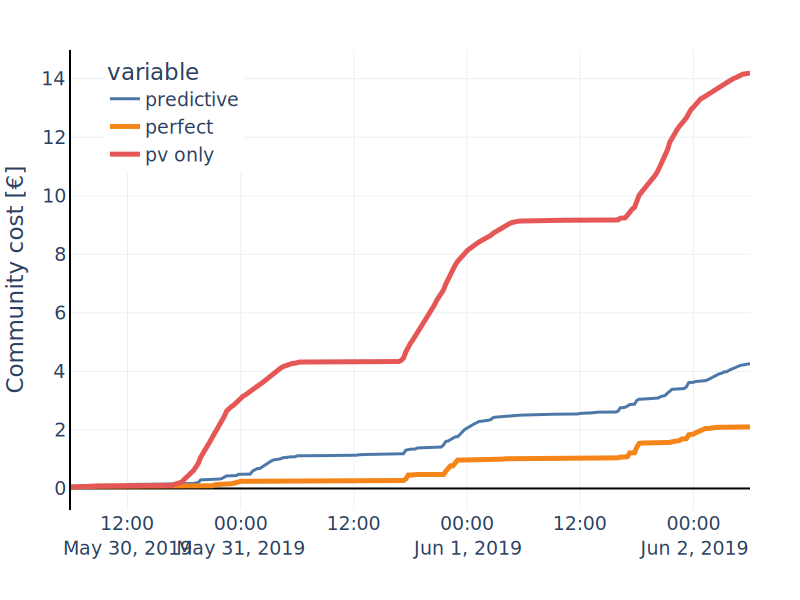

                     predictive  perfect  pv only
2019-06-02 06:00:00       4.263    2.103   14.195


In [18]:
#graph = graph.resample("60T").last()
fig = px.line(graph.loc[:end_complete_pred, :])

fig.data[1].update(line_width=5)
fig.data[0].update(line_width=3)
fig.data[-1].update(line_width=5)
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=True,
    legend={"x": 0.05},
    xaxis_title="",
    yaxis_title="Community cost [€]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
#fig.write_image(f"results/cumsum_community_import_all_freq.svg")
print(graph.tail(1))

In [19]:
# Price without solar panel
print(f"{round((load.loc[_start:_end, :].sum(axis=0) / 4 * 0.1740).sum(), 2)} € for 5 members during 3 days")

27.2 € for 5 members during 3 days


In [20]:
# Price at the end of the month per member
print(f"{round((load.loc[_start:_end, :].sum(axis=0) / 4 * 0.1740).sum() / 5 / 3 * 31, 2)} €/member/month")

56.2 €/member/month


En moyenne, un ménage français consomme donc 12,5 KWh par jour, ou 4590 KWh par an. Mais de très fortes disparités existent comme le montre le tableau ci-dessous.
https://www.lenergietoutcompris.fr/actualites-conseils/quelle-est-la-consommation-delectricite-moyenne-par-jour-en-france

In [21]:
# Consumption per day
load.loc[_start:_end, :].sum(axis=0) / 4 / 3

2000989    10.867934
2000964     8.249540
2000926    11.882422
2001139    13.182364
2000960     7.916382
dtype: float64

# II - Reactive approach

In [22]:
def battery_constraints(in_kw, soc_kwh, spec, deltat_minute):
    # Energy
    offset = spec["max_kwh"] * spec["offset"]
    max_charg_kW = max(
        0, (spec["max_kwh"] - offset - soc_kwh) / (spec["eta"] * deltat_minute / 60)
    )
    if in_kw > max_charg_kW:
        in_kw = max_charg_kW

    max_discharg_kW = min(0, (0 + offset - soc_kwh) * spec["eta"] / (deltat_minute / 60))
    if in_kw < max_discharg_kW:
        in_kw = max_discharg_kW

    # Power
    if in_kw > spec["max_kw"]:
        in_kw = spec["max_kw"]

    if in_kw < -spec["min_kw"]:
        in_kw = -spec["min_kw"]
    return in_kw

def update_soc(in_kw, previous_soc_kwh, spec, deltat_minute):
    # Power
    assert in_kw <= spec["max_kw"], f"{in_kw} <= {spec['max_kw']}"
    assert in_kw >= -spec["min_kw"], f"{in_kw} >= {-spec['min_kw']}"

    # Energy
    if in_kw > 0:
        _eta = spec["eta"]
    else:
        _eta = 1 / spec["eta"]
    new_soc_kwh = previous_soc_kwh + _eta * in_kw * deltat_minute / 60
    assert new_soc_kwh <= spec["max_kwh"], f"{new_soc_kwh}"
    assert new_soc_kwh >= 0, f"{new_soc_kwh}"
    return new_soc_kwh

def collective_storage_control(df, house_names, deltat_minute, spec):
    """Change input df
    """
    if deltat_minute != 1:
        assert pd.infer_freq(df.index) == f"{deltat_minute}T"
    else:
        assert pd.infer_freq(df.index) == "T"
    
    in_kws = {name:list([0]) for name in house_names}
    soc_kwhs = {name:list([spec["max_kwh"] * spec["offset"]]) for name in house_names}
    
    for index, row in df[house_names].iterrows():
        netload = row.to_dict()
        
        if index.minute % 15 == 0:
            for name in house_names:
                in_kws[name].append(0)
                soc_kwhs[name].append(soc_kwhs[name][-1])
            
            last_netload = dict(netload)
            continue
            
        if (index.minute + deltat_minute) % 15 == 0:
            for name in house_names:
                last_netload[name] *= 2
        
        for name in house_names:
            in_kw = - last_netload[name]
            in_kw = battery_constraints(in_kw, soc_kwhs[name][-1], spec, deltat_minute)
            soc_kwh = update_soc(in_kw, soc_kwhs[name][-1], spec, deltat_minute)
            in_kws[name].append(in_kw)
            soc_kwhs[name].append(soc_kwh)
        
        community_netload = sum(last_netload[name] + in_kws[name][-1] for name in house_names)
        
        order = [(name, float(soc_kwhs[name][-1])) for name in house_names]
        if community_netload <= 0:
            order = sorted(order, key=lambda tup: tup[1], reverse=False)  # normal order 1, 2, 3 .. lowest soc
            assert order[0][1] <= order[-1][1]
        else:
            order = sorted(order, key=lambda tup: tup[1], reverse=True)  # Reverse normal order to get highest soc
            assert order[0][1] >= order[-1][1]
        
        # Overwrite individual commands for the most available batteries
        for name, _ in order:
            in_kw = in_kws[name][-1] - community_netload
            in_kw = battery_constraints(in_kw, soc_kwhs[name][-2], spec, deltat_minute)
            
            community_netload += in_kw - in_kws[name][-1]
            
            soc_kwh = update_soc(in_kw, soc_kwhs[name][-2], spec, deltat_minute)
            soc_kwhs[name][-1] = soc_kwh
            in_kws[name][-1] = in_kw
        
        last_netload = dict(netload)
    
    for name in house_names:
        del in_kws[name][0]    
        del soc_kwhs[name][0]     
        df[f"{name}_storage"] = in_kws[name]
        df[f"{name}_soc"] = soc_kwhs[name]
    return df

In [23]:
comm_freq = "3T"
tmp = netload.loc[end_training + deltat:end_complete_pred, :].copy()
tmp = tmp.resample(comm_freq).ffill()

result = collective_storage_control(tmp, sub_house_ids, int(comm_freq[0]), dict(ref_spec))

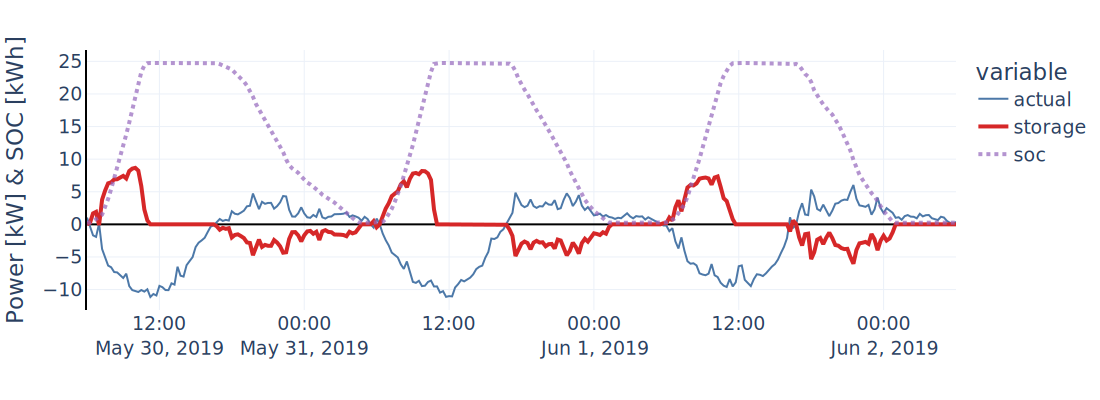

In [24]:
graph = netload.loc[_start:_end, sub_house_ids].copy()
graph["actual"] = graph.sum(axis=1)
graph = graph[["actual"]]

graph["storage"] = result[[f"{name}_storage" for name in sub_house_ids]].sum(axis=1).resample("15T").mean()
graph["soc"] = result[[f"{name}_soc" for name in sub_house_ids]].sum(axis=1).resample("15T").mean()

fig = px.line(graph, y=["actual", "storage", "soc"])
#fig.data[1].update(line_width=3, opacity=0.8)
fig.data[1].update(line_width=4, 
                   line_color="rgba(214, 39, 40, 1.0)")
fig.data[2].update(line_width=4, 
                   line_dash="dot", line_color="rgba(148, 103, 189, 0.7)")
fig.update_layout(
    layout,
    height=400,
    width=1100,
    showlegend=True,
    xaxis_title="",
    yaxis_title="Power [kW] & SOC [kWh]",
    yaxis_dtick=5,
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

## Result in €

In [25]:
graph = saved_graph.copy()

# Reactive
total_netloads = result[[f"{name}_storage" for name in sub_house_ids]].copy()
total_netloads.columns = sub_house_ids
for col in total_netloads.columns:
    total_netloads[col] += netload.loc[_start:_end, col].resample(comm_freq).ffill()
total_netloads = total_netloads.resample("15T").mean()
costs = cost_wrapper(total_netloads)
graph["reactive"] = costs

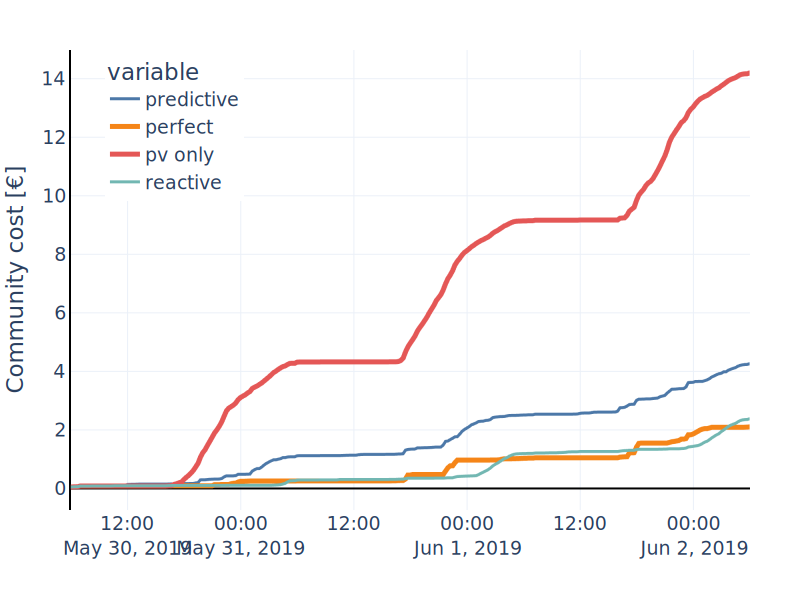

                     predictive  perfect  pv only  reactive
2019-06-02 06:00:00       4.263    2.103   14.195     2.381


In [26]:
#graph = graph.resample("60T").last()
fig = px.line(graph.loc[:end_complete_pred, :])

fig.data[1].update(line_width=5)
fig.data[0].update(line_width=3)
fig.data[-1].update(line_width=3)
fig.data[-2].update(line_width=5)
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=True,
    legend={"x": 0.05},
    xaxis_title="",
    yaxis_title="Community cost [€]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
fig.write_image(f"results/community_cost.svg")
print(graph.tail(1))

# II - Reactive with uncertainties

In [32]:
variance = 0.3
costs = []
saved_noise = netload.loc[_start:_end].copy()
saved_noise = saved_noise.resample(comm_freq).ffill()
saved_noise.drop(columns=saved_noise.columns, inplace=True)

for j in tqdm(list(range(0, 100)), desc="Sample"):
    noise = netload.loc[_start:_end].copy()
    noise = noise.resample(comm_freq).ffill()

    for name in sub_house_ids:
        for begin in pd.date_range(noise.index[0], noise.index[-1], freq="2H"):
            _range = slice(begin, begin + timedelta(hours=2) - timedelta(minutes=3))
            sum_brefore = noise.loc[_range, name].sum()
            
            ratio = 9999
            while (ratio > 2) or (ratio < 0.5):
                numpy_noise = np.random.normal(0, variance, len(noise.loc[_range, name]))
                tmp = noise.loc[_range, name].copy()
                tmp += np.clip(numpy_noise, -1, 1)
                sum_after = tmp.sum()
                ratio = sum_brefore / sum_after
                
            noise.loc[_range, name] += np.clip(numpy_noise, -1, 1)
            noise.loc[_range, name] *= ratio

            np.testing.assert_almost_equal(
                sum_brefore, noise.loc[_range, name].sum(),
                decimal=6, verbose=True)
    saved_noise[j] = noise.sum(axis=1)

    result = collective_storage_control(noise, sub_house_ids, int(comm_freq[0]), dict(ref_spec))

    graph = result.copy()
    for col in sub_house_ids:
        graph[col] += graph[f"{col}_storage"]

    reactive_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=3, buy_price=0.1740, exchange_price=0.0371)
    costs.append(reactive_cost)

Sample: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


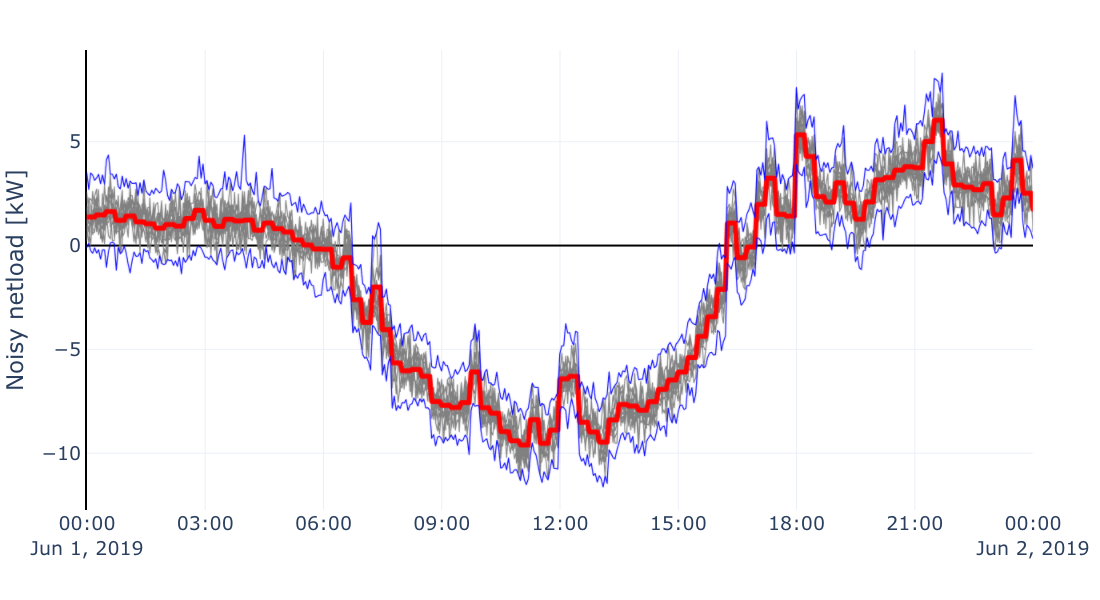

In [52]:
graph = saved_noise.loc[:, [a for a in range(0, 10)]].copy()
graph["basic"] = netload.loc[_start:_end].sum(axis=1).resample(comm_freq).ffill()
graph["max"] = saved_noise.max(axis=1)
graph["min"] = saved_noise.min(axis=1)

fig = px.line(graph.loc[datetime(2019, 6, 1, 0, 0, 0):datetime(2019, 6, 2, 0, 0, 0), :])
fig.update_traces(line_width=1, line_color="grey")

fig.data[-2].update(line_width=1, line_color="blue")
fig.data[-1].update(line_width=1, line_color="blue")
fig.data[-3].update(line_width=5, line_color="red")
fig.update_layout(
    layout,
    height=600,
    width=1100,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Noisy netload [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show(renderer="png")

3.0365
3.0400400000000007


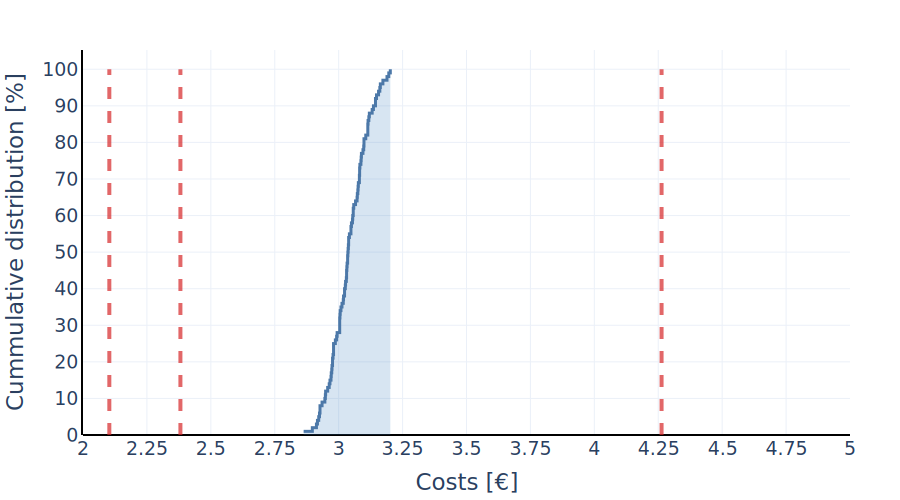

In [34]:
graph = pd.DataFrame(index=list(range(0, len(costs))), data={"costs": costs})
#graph = graph[graph.costs < 50]
print(graph.costs.median())
print(graph.costs.mean())


fig = px.ecdf(graph, x=["costs"], ecdfnorm="percent")
#fig.data[0]["x"] = fig.data[0]["x"][:-39]
#fig.data[0]["y"] = fig.data[0]["y"][:-39]
fig.update_traces(line_width=3, fillcolor="rgba(55, 128, 191, 0.2)", fill="tozeroy")

# Red dashed line
fig.add_shape(
 type='line',
 x0=2.103, x1=2.103, y0=0, y1=100,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.add_shape(
 type='line',
 x0=2.381, x1=2.381, y0=0, y1=100,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.add_shape(
 type='line',
 x0=4.263, x1=4.263, y0=0, y1=100,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    xaxis_range=[2, 5],
    xaxis_dtick=0.25,
    yaxis_dtick=10,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="Costs [€]",
    yaxis_title="Cummulative distribution [%]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
)
fig.show()